In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import flopy
from gsflow.builder import GenerateFishnet, FlowAccumulation
from gsflow.builder import ModflowBuilder
import pdb

#################################################
# Input path management
##################################################

# set our cell size in meters.  #I'll start out with 100m for now, but will likely refine
cellsize=100
method = "nearest"

#model name
model_name = "RattlesnakeCreek_%3im"%cellsize+method

#toplevel ouput path
model_path = os.path.join("models",model_name)

#derived output path
gis_derived_path = os.path.join(model_path,"gis_deriv")
#file names
dfname = "DEMResampledFA.txt"
watershedname = "watershed.txt"
gridname = "grid.bin"
streamfilename = "streams.bin"

## set the path to the mfnwt executable 
   # This either needs to be hardcoded, be in the system path, or be
   # in same directory as scripts.

## shapefile pour point
dem_file = os.path.join(gis_derived_path, dfname)
watershed_file = os.path.join(gis_derived_path, watershedname)
mg_file = os.path.join(model_path, gridname)

# define the stream information binary data path
stream_file = os.path.join(model_path, streamfilename)

#######################################################
#Load Data
#######################################################
# load modelgrid, dem, watershed, and stream information file
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_file)
watershed = np.genfromtxt(watershed_file, dtype=int)
strm_obj = FlowAccumulation.load_streams(stream_file)

#######################################################
#Build Initial MODFLOW model in one step
#######################################################
# create a new modflow builder object
#model_name="ElkCreek_100m"
mfbuild = ModflowBuilder(modelgrid, dem_data, model_name)

########
#1 Layer for now
########
# set the botm elevation to be 100 m less than the top
botm = dem_data - 100
# reshape the array to (nlay,nrow,ncol)
botm.shape = (1, modelgrid.nrow, modelgrid.ncol)

# build the model
mf = mfbuild.build_all(
    strm_obj.reach_data,
    strm_obj.segment_data,
    strm_obj.irunbnd,
    finf=np.ones(dem_data.shape),
    botm=botm,
    ibound=watershed,
    iuzfbnd=watershed
)


In [2]:
##################################################
# Modify Discretization package for three layers
##################################################
mf.dis


    MODFLOW Discretization Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.Modflow`) to which
        this package will be added.
    nlay : int
        Number of model layers (the default is 1).
    nrow : int
        Number of model rows (the default is 2).
    ncol : int
        Number of model columns (the default is 2).
    nper : int
        Number of model stress periods (the default is 1).
    delr : float or array of floats (ncol), optional
        An array of spacings along a row (the default is 1.0).
    delc : float or array of floats (nrow), optional
        An array of spacings along a column (the default is 0.0).
    laycbd : int or array of ints (nlay), optional
        An array of flags indicating whether or not a layer has a Quasi-3D
        confining bed below it. 0 indicates no confining bed, and not zero
        indicates a confining bed. LAYCBD for the bottom layer must be 0. (the
    

In [3]:
#set up for multiple layers
#number of layers
nlay=3
# layer thicknesses
lay1 = 2
lay2 = 10
lay3 = 100

#change bottom elevations
botm=np.zeros((nlay, mf.dis.nrow, mf.dis.ncol))
botm[0,:,:]=mf.dis.top.array-lay1
botm[1,:,:]=mf.dis.top.array-(lay1+lay2)
botm[2,:,:]=mf.dis.top.array-(lay1+lay2+lay3)

#change layer cbd (confined boundary at bottom
laycbd=np.zeros((nlay))


In [4]:
botm.shape

(3, 316, 405)

In [5]:
# create discretization object with updated parameters
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=mf.dis.nrow,
    ncol=mf.dis.ncol,
    nper=2,
    delr=mf.dis.delr,
    delc=mf.dis.delc,
    laycbd=laycbd,
    top=mf.dis.top,
    botm=botm,
    perlen=[1,1],
    nstp=[1,500],
    tsmult=[1,1],
    steady=[True, False],
    itmuni=mf.dis.itmuni,
    lenuni=mf.dis.lenuni
)

/Users/payton.gardner/soft/miniconda3/envs/gsflow/lib/python3.11/site-packages/flopy/mbase.py:659: UserWarning: Unit 11 of package DIS already in use.
  warn(
/Users/payton.gardner/soft/miniconda3/envs/gsflow/lib/python3.11/site-packages/flopy/mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'DIS' package.
  warn(


In [6]:
##################################################
# Modify UPW package for multiple layers
##################################################
mf.upw


    Upstream weighting package class


    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ipakcb : int, optional
        Toggles whether cell-by-cell budget data should be saved. If None or zero,
        budget data will not be saved (default is None).
    hdry : float
        Is the head that is assigned to cells that are converted to dry during
        a simulation. Although this value plays no role in the model
        calculations, it is useful as an indicator when looking at the
        resulting heads that are output from the model. HDRY is thus similar
        to HNOFLO in the Basic Package, which is the value assigned to cells
        that are no-flow cells at the start of a model simulation. (default
        is -1.e30).
    iphdry : int
        iphdry is a flag that indicates whether groundwater head will be set
        to hdry when the groundwater head is

In [7]:
# types of aquifers (0 is confined, 1 is convertible)
lay1 = 1
lay2 = 1
lay3 = 1  #all convertible for now.  Might want to change this to 0 if not converging
laytyp = np.array([lay1, lay2, lay3])

# hydraulic conductivity array
hk_lay1 = 1e-3*86400 #m/d
hk_lay2 = 5e-5*86400 #m/d
hk_lay3 = 1e-6*86400 #m/d
hk = np.ones((nlay, mf.dis.nrow, mf.dis.ncol))
hk[0,:,:] = hk_lay1
hk[1,:,:] = hk_lay2
hk[2,:,:] = hk_lay3

# specific storage
ss_lay1 = 1e-6
ss_lay2 = 1e-7
ss_lay3 = 1e-8
ss = np.ones((nlay, mf.dis.nrow, mf.dis.ncol))
ss[0,:,:] = ss_lay1
ss[1,:,:] = ss_lay2
ss[2,:,:] = ss_lay3

# specific yield
sy_lay1 = 0.4
sy_lay2 = 0.2
sy_lay3 = 0.01
sy = np.ones((nlay, mf.dis.nrow, mf.dis.ncol))
sy[0,:,:] = sy_lay1
sy[1,:,:] = sy_lay2
sy[2,:,:] = sy_lay3

# layer vka
layvka = np.ones(nlay)

# set up new upw package
upw = flopy.modflow.ModflowUpw(
    mf,
    laytyp=laytyp,
    layvka=layvka,
    hk=hk,
    ss=ss,
    sy=sy,
)


/Users/payton.gardner/soft/miniconda3/envs/gsflow/lib/python3.11/site-packages/flopy/mbase.py:659: UserWarning: Unit 31 of package UPW already in use.
  warn(
/Users/payton.gardner/soft/miniconda3/envs/gsflow/lib/python3.11/site-packages/flopy/mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'UPW' package.
  warn(


In [8]:
print(laytyp)
print(hk.shape)
print(ss.shape)
print(sy.shape)
print(layvka)

[1 1 1]
(3, 316, 405)
(3, 316, 405)
(3, 316, 405)
[1. 1. 1.]


In [9]:
##################################################
# Modify BAS6 package for multiple layers
##################################################
mf.bas6


    MODFLOW Basic Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ibound : array of ints, optional
        The ibound array (the default is 1).
    strt : array of floats, optional
        An array of starting heads (the default is 1.0).
    ifrefm : bool, optional
        Indication if data should be read using free format (the default is
        True).
    ixsec : bool, optional
        Indication of whether model is cross sectional or not (the default is
        False).
    ichflg : bool, optional
        Flag indicating that flows between constant head cells should be
        calculated (the default is False).
    stoper : float
        percent discrepancy that is compared to the budget percent discrepancy
        continue when the solver convergence criteria are not met.  Execution
        will unless the budget percent discrepancy is greate

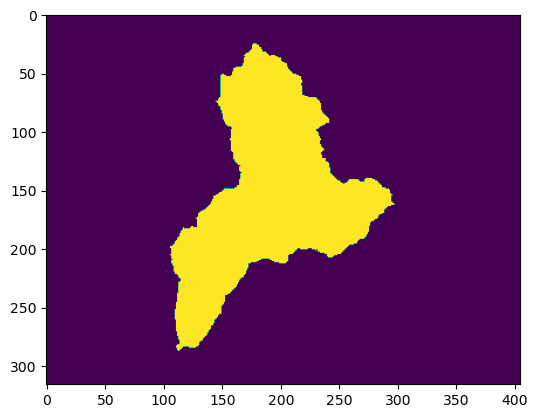

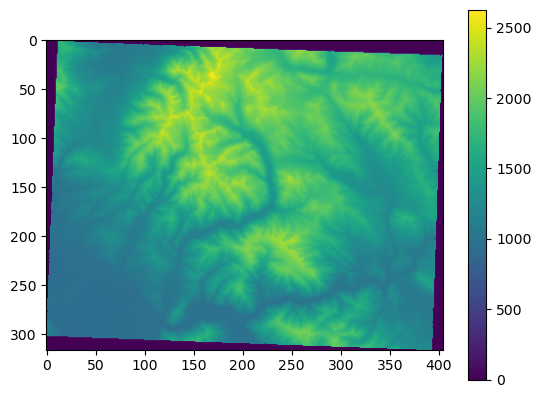

In [10]:
# create ibound array
ibd1 = mf.bas6.ibound.array
ibound = np.zeros((nlay, mf.dis.nrow, mf.dis.ncol))
ibound[0,:,:] = ibd1[0,:,:]
ibound[1,:,:] = ibd1[0,:,:]
ibound[2,:,:] = ibd1[0,:,:]
plt.imshow(ibound[0,:,:])

# create strt array
strt = np.ones((nlay, mf.dis.nrow, mf.dis.ncol))
strt[0,:,:] = mf.dis.top.array
strt[1,:,:] = mf.dis.top.array
strt[2,:,:] = mf.dis.top.array
plt.figure()
plt.imshow(mf.dis.top.array)
plt.colorbar()

In [11]:
print(ibound.shape)
print(strt.shape)

(3, 316, 405)
(3, 316, 405)


In [12]:
# set up new bas6 package
bas6 = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

/Users/payton.gardner/soft/miniconda3/envs/gsflow/lib/python3.11/site-packages/flopy/mbase.py:659: UserWarning: Unit 13 of package BAS6 already in use.
  warn(
/Users/payton.gardner/soft/miniconda3/envs/gsflow/lib/python3.11/site-packages/flopy/mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'BAS6' package.
  warn(


In [13]:
#####################################################
# Modify the UZF package
#####################################################
mf.uzf


    MODFLOW Unsaturated Zone Flow 1 Boundary Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    nuztop : integer
        used to define which cell in a vertical column that recharge and
        discharge is simulated. (default is 1)

        1   Recharge to and discharge from only the top model layer. This
            option assumes land surface is defined as top of layer 1.
        2   Recharge to and discharge from the specified layer in variable
            IUZFBND. This option assumes land surface is defined as top of
            layer specified in IUZFBND.
        3   Recharge to and discharge from the highest active cell in each
            vertical column. Land surface is determined as top of layer
            specified in IUZFBND. A constant head node intercepts any recharge
            and prevents deeper percolation.

    iuzfopt : integer

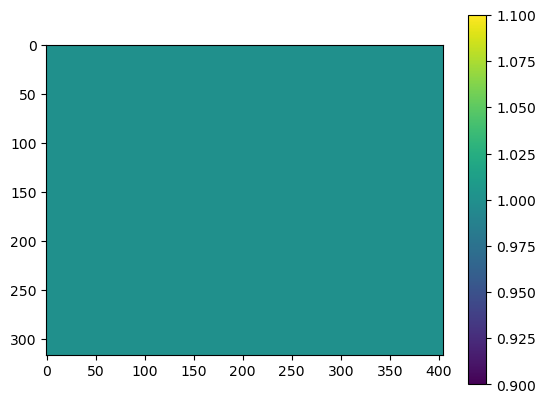

In [14]:
plt.imshow(mf.uzf.finf.array[0,0,:,:])
plt.colorbar()

/Users/payton.gardner/soft/miniconda3/envs/gsflow/lib/python3.11/site-packages/flopy/mbase.py:659: UserWarning: Unit 19 of package UZF already in use.
  warn(
/Users/payton.gardner/soft/miniconda3/envs/gsflow/lib/python3.11/site-packages/flopy/mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'UZF' package.
  warn(


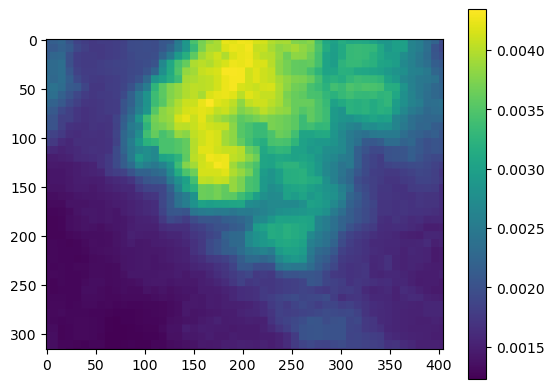

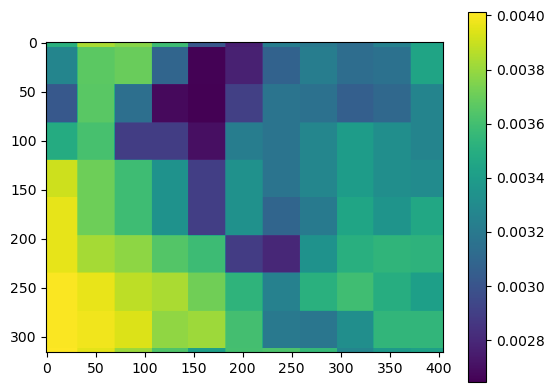

In [15]:
# Load the resampled mean infiltration data
precipresampled_file = 'precipresampled.txt'
precipresampled_file = os.path.join(gis_derived_path,precipresampled_file)

# load using np.genfromtxt
precipresampled = np.genfromtxt(precipresampled_file)

# modify

# create new array
inf = precipresampled
finf = {0: inf, 1: 1.05*inf}

# plot
plt.imshow(inf)
plt.colorbar()

# Load teh resampled mean evapotranspiration data
etresampled_file = 'etrresampled.txt'
etresampled_file = os.path.join(gis_derived_path,etresampled_file)
etresampled = np.genfromtxt(etresampled_file)
etr = {0: etresampled/10000, 1: etresampled/10000}

# plot
plt.figure()
plt.imshow(etr[1])
plt.colorbar()


# set up new uzf package, use all object values currently used but update finf
uzf = flopy.modflow.ModflowUzf1(
    model=mf,
    capillaryuzet = False,
    finf = finf,
    ietflg = 1,
    pet=etr,
    etsquare=0.1,
    ipakcb = 0,
    irunbnd = mf.uzf.irunbnd,
    irunflg = 1,
    iuzfbnd = mf.uzf.iuzfbnd,
    iuzfcb2 = 0,
    iuzfopt = 1,
    nosurfleak = False,
    nsets = 20,
    ntrail2 = 10,
    nuztop = 1,
    options = None,
    rejectsurfk = False,
    seepsurfk = False,
    specifysurfk = False,
    specifythti = False,
    specifythtr = False,
    surfdep = 1.0,
    thti = mf.uzf.thti,
    thts = mf.uzf.thts,
    vks = mf.uzf.vks,
)

In [16]:
##########################
# Update SFR
##########################

#example values for now, but likely need to be tuned for the model later.

# stream roughness for the segments.  
# update roughch in segment data - all constant and set to 0.04 for now.  Can be tuned later.
mf.sfr.segment_data[0]["roughch"] = 0.04

# update strhc1 in reach data.
mf.sfr.reach_data["strhc1"] = 0.1



In [17]:
##########################
# Offset the Model GRID to match location
##########################
# copy the coordinate information from the modelgrid we built in the Fishnet
mf.modelgrid.set_coord_info(
    xoff=modelgrid.xoffset, 
    yoff=modelgrid.yoffset
)

In [18]:
##########################
# Write Input Files
##########################
# change the path of the model and write to file
mf.change_model_ws(model_path)
mf.write_input()

In [19]:
#######################################################
#RUN MODFLOW 
#######################################################
mf.exe_name = 'mfnwt'
success, buff = mf.run_model(silent=False)
print(buff)


FloPy is using the following executable to run the model: ../../../../../soft/modflow/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: RattlesnakeCreek_100mnearest.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/25 18:00:30

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     4 

In [20]:
head_file = os.path.join(model_path, model_name+".hds")
hds = flopy.utils.HeadFile(head_file)
hds.get_times()

[1.0]

(3, 316, 405)


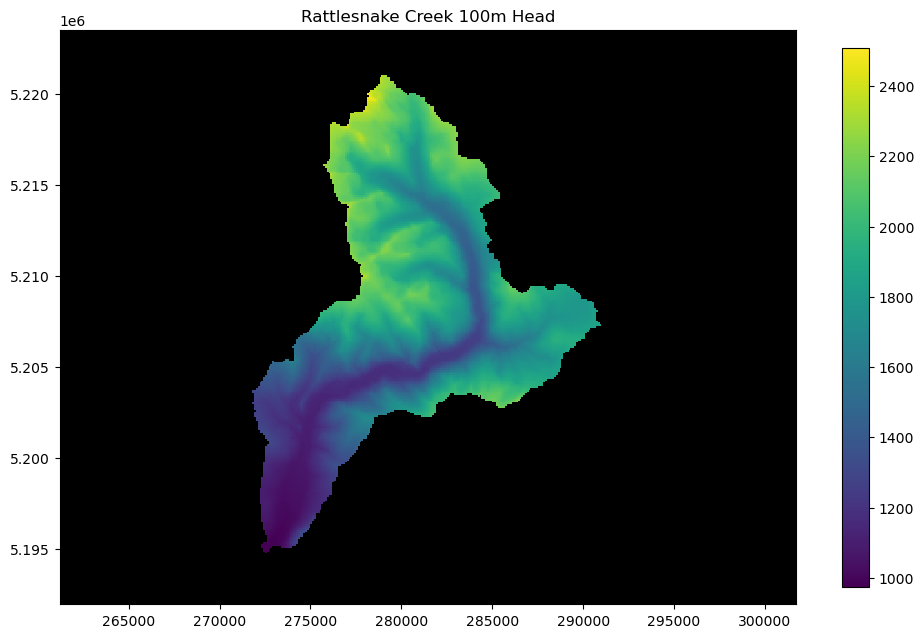

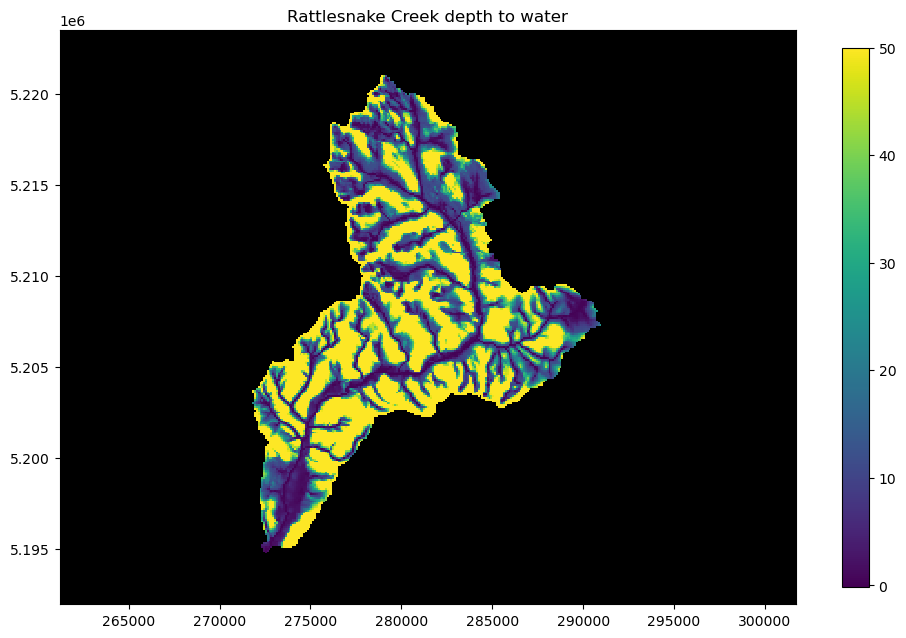

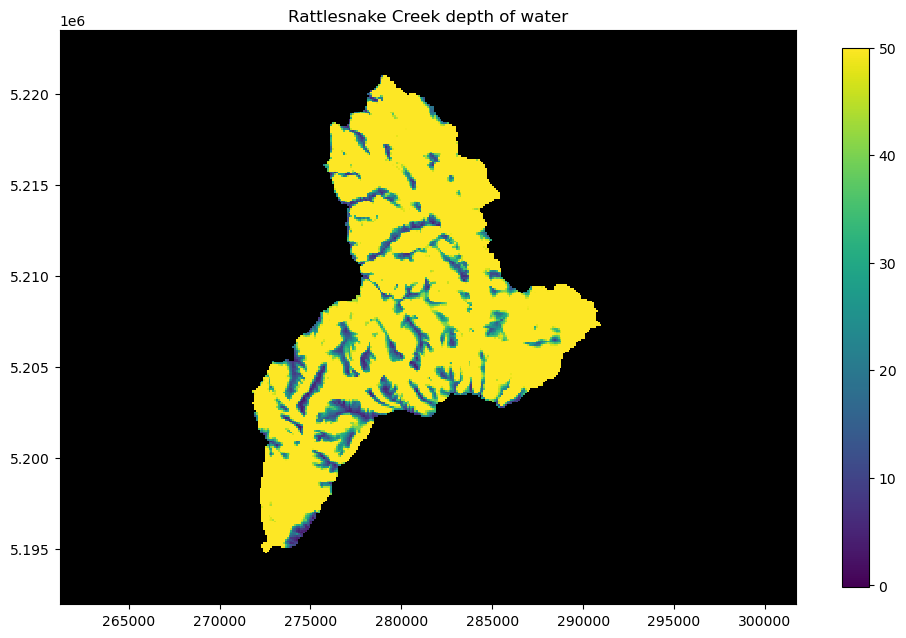

In [21]:

#######################################################
#Visualize the solution
#######################################################
# define the headfile path
head_file = os.path.join(model_path, model_name+".hds")

# load the headfile
hds = flopy.utils.HeadFile(head_file)

# get data
heads = hds.get_alldata()[-1]
print(heads.shape)

# make a plot of the heads
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(model=mf, ax=ax)
pc = pmv.plot_array(heads[0,:,:])
#pc = pmv.plot_array(mf.dis.top.array-heads[0,:,:])
#pc = pmv.plot_array(heads[0,:,:]-botm[-1,:,:])
#pc.set_clim(50, 0)
#pc.set_clim(0, 112)
#pc.set_clim(112, 0)
ib = pmv.plot_inactive()
plt.colorbar(pc, shrink=0.7)
#change scale on the plot to better visualize the difference
ax.set_title("Rattlesnake Creek 100m Head")
fig.tight_layout()

# make a plot of the depth to water
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(1, 1, 1, aspect="equal")
pmv2 = flopy.plot.PlotMapView(model=mf, ax=ax2)
pc2 = pmv2.plot_array(mf.dis.top.array-heads[0,:,:])
#pc = pmv.plot_array(heads[0,:,:]-botm[-1,:,:])
pc2.set_clim(50, 0)
#pc.set_clim(0, 112)
#pc.set_clim(112, 0)
ib2 = pmv2.plot_inactive()
plt.colorbar(pc2, shrink=0.7)
#change scale on the plot to better visualize the difference
plt.title("Rattlesnake Creek depth to water")
plt.tight_layout()

# make a plot of the depth of water
fig3 = plt.figure(figsize=(10, 8))
ax3 = fig3.add_subplot(1, 1, 1, aspect="equal")
pmv3 = flopy.plot.PlotMapView(model=mf, ax=ax3)
pc3 = pmv3.plot_array(heads[0,:,:]-botm[-1,:,:])
pc3.set_clim(50, 0)
#pc.set_clim(0, 112)
#pc.set_clim(112, 0)
ib3 = pmv3.plot_inactive()
plt.colorbar(pc3, shrink=0.7)
#change scale on the plot to better visualize the difference
plt.title("Rattlesnake Creek depth of water")
plt.tight_layout()

plt.show()